In [1]:
# Importing Libraries
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Defining the transform (padding for lenet)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor()
])

In [4]:
# Loading dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [5]:
# Splitting training set for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

## <b>Using the LeNet-5 Architecture</b>

In [7]:
lenet_5 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5),           # C1: Conv (5x5), 6 filters
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),    # S1: Avg Pooling (2x2)

    torch.nn.Conv2d(6, 16, kernel_size=5),          # C2: Conv (5x5), 16 filters
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),    # S2: Avg Pooling (2x2)

    torch.nn.Flatten(),                             # Flatten for FC layers

    torch.nn.Linear(5*5*16, 120),                   # F3: Fully connected
    torch.nn.Tanh(),
    torch.nn.Linear(120, 84),                       # F4: Fully connected
    torch.nn.Tanh(),
    torch.nn.Linear(84, 10),                        # F5: Output Layer
)

print(lenet_5)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Tanh()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Tanh()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet_5.parameters(), lr=0.01)

In [9]:
# Training Loop
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(25):
    lenet_5.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lenet_5(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, pred = outputs.max(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    lenet_5.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = lenet_5(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, pred = outputs.max(1)
            val_correct += (pred == labels).sum().item()
            val_total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"Epoch {epoch+1}: "
      f"Train Loss={train_losses[-1]:.4f}, Train Acc={train_accs[-1]*100:.2f}%, "
      f"Val Loss={val_losses[-1]:.4f}, Val Acc={val_accs[-1]*100:.2f}%")

Epoch 1: Train Loss=2.1428, Train Acc=36.05%, Val Loss=1.5550, Val Acc=60.08%
Epoch 2: Train Loss=0.9015, Train Acc=76.74%, Val Loss=0.5823, Val Acc=84.52%
Epoch 3: Train Loss=0.4866, Train Acc=86.62%, Val Loss=0.4119, Val Acc=88.75%
Epoch 4: Train Loss=0.3749, Train Acc=89.48%, Val Loss=0.3375, Val Acc=90.40%
Epoch 5: Train Loss=0.3172, Train Acc=90.93%, Val Loss=0.2914, Val Acc=91.52%
Epoch 6: Train Loss=0.2783, Train Acc=91.79%, Val Loss=0.2593, Val Acc=92.48%
Epoch 7: Train Loss=0.2479, Train Acc=92.66%, Val Loss=0.2318, Val Acc=93.35%
Epoch 8: Train Loss=0.2227, Train Acc=93.38%, Val Loss=0.2097, Val Acc=93.85%
Epoch 9: Train Loss=0.2015, Train Acc=93.98%, Val Loss=0.1927, Val Acc=94.38%
Epoch 10: Train Loss=0.1831, Train Acc=94.58%, Val Loss=0.1751, Val Acc=95.01%
Epoch 11: Train Loss=0.1673, Train Acc=95.01%, Val Loss=0.1623, Val Acc=95.55%
Epoch 12: Train Loss=0.1536, Train Acc=95.46%, Val Loss=0.1506, Val Acc=95.83%
Epoch 13: Train Loss=0.1419, Train Acc=95.82%, Val Loss=0.139

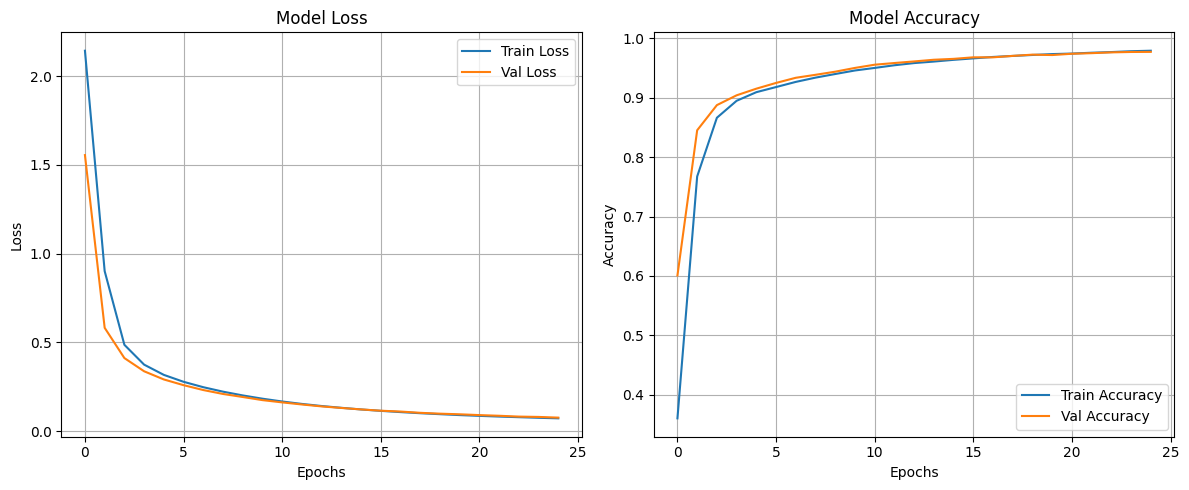

In [10]:
# Plotting loss and accuracies
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(val_losses, label='Val Loss')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(train_accs, label='Train Accuracy')
axs[1].plot(val_accs, label='Val Accuracy')
axs[1].set_title('Model Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

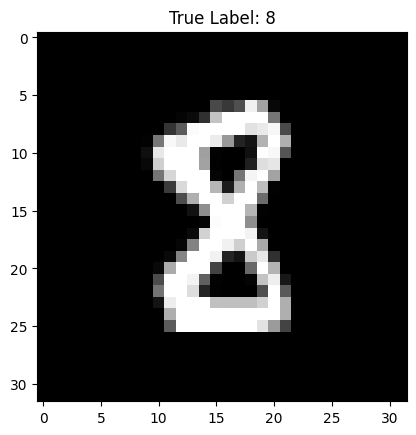

In [11]:
# Making Prediction
lenet_5.eval()
sample_img, label = test_dataset[179]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f'True Label: {label}')
plt.show()

In [12]:
with torch.no_grad():
    sample_img = sample_img.unsqueeze(0).to(device)
    output = lenet_5(sample_img)
    prob = torch.nn.functional.softmax(output, dim=1)
    print(f"Softmax Probabilites: {prob.cpu().numpy()}")
    print(f"Predicted Digit: {torch.argmax(prob).item()}")

Softmax Probabilites: [[3.2994234e-05 1.8448685e-03 7.0555792e-03 5.3113647e-04 1.9532811e-06
  4.6566263e-05 4.2799511e-05 5.4479992e-06 9.9042165e-01 1.6884092e-05]]
Predicted Digit: 8


In [13]:
# Saving the model
torch.save(lenet_5.state_dict(), 'lenet5_mnist.pth')

<hr>